In [9]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 2
MAX_TRAIN_IMAGES = 350


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(2, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, None, None, 3), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(2, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, None, None, 3), dtype=tf.float32, name=None))>


In [11]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [12]:
def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

In [13]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

In [14]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

Epoch 1/70


2023-03-05 21:15:21.375198: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7096cfd260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 21:15:21.375456: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2023-03-05 21:15:21.400884: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-05 21:15:21.643302: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-05 21:15:21.733141: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 [==============================] - ETA: 0s - loss: 0.1740 - peak_signal_noise_ratio: 63.2356
Epoch 1: saving model to checkpoints
175/175 [==============================] - 421s 1s/step - loss: 0.1740 - peak_signal_noise_ratio: 63.2356 - val_loss: 0.1150 - val_peak_signal_noise_ratio: 66.4198 - lr: 1.0000e-04
Epoch 2/70
175/175 [==============================] - ETA: 0s - loss: 0.1555 - peak_signal_noise_ratio: 64.2434
Epoch 2: saving model to checkpoints
175/175 [==============================] - 167s 956ms/step - loss: 0.1555 - peak_signal_noise_ratio: 64.2434 - val_loss: 0.1237 - val_peak_signal_noise_ratio: 66.0946 - lr: 1.0000e-04
Epoch 3/70
175/175 [==============================] - ETA: 0s - loss: 0.1543 - peak_signal_noise_ratio: 64.3904
Epoch 3: saving model to checkpoints
175/175 [==============================] - 168s 960ms/step - loss: 0.1543 - peak_signal_noise_ratio: 64.3904 - val_loss: 0.1160 - val_peak_signal_noise_ratio: 66.5958 - lr: 1.0000e-04
Epoch 4/70
175/

INFO:tensorflow:Assets written to: mirnet/assets


INFO:tensorflow:Assets written to: mirnet/assets


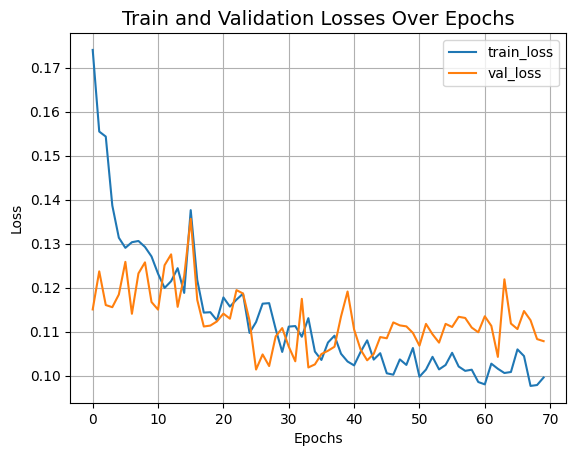

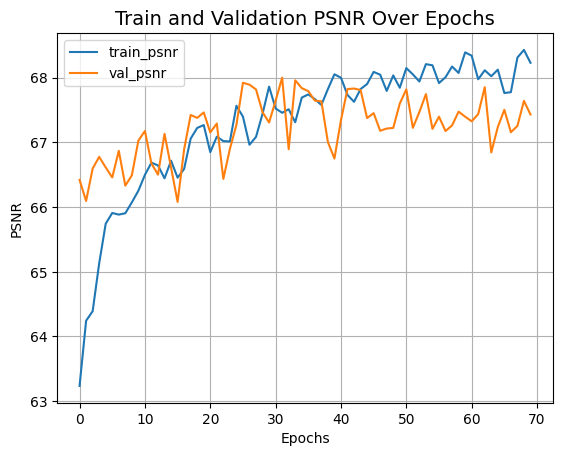

In [15]:
cbl = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoints",
        save_best_only=False,
        save_weights_only=True,
        verbose=1
    )
]

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=70,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        ),
        cbl
    ],
)

model.save("mirnet")

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [16]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image

2023-03-06 10:11:28.885715: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 11s 11s/step


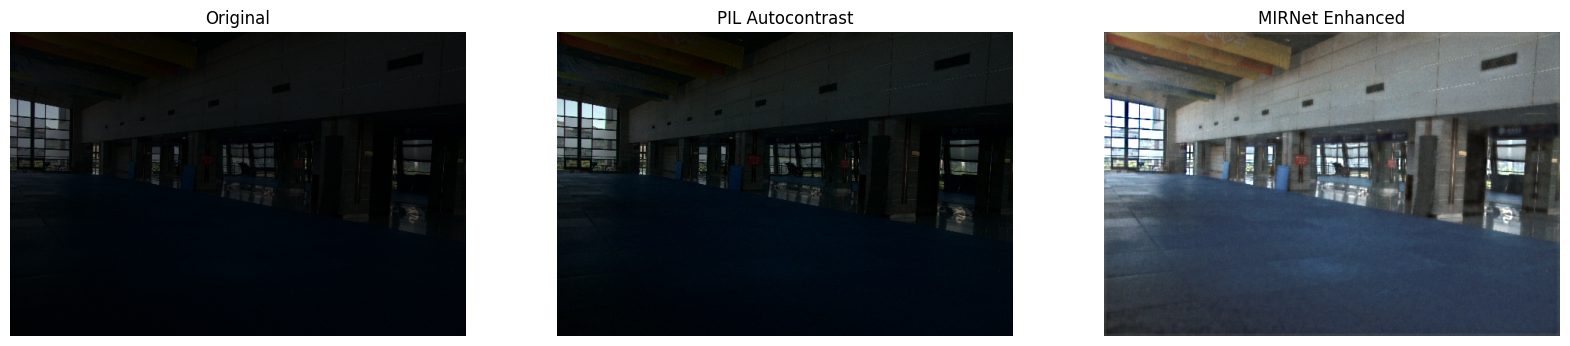

1/1 [==============================] - 1s 658ms/step


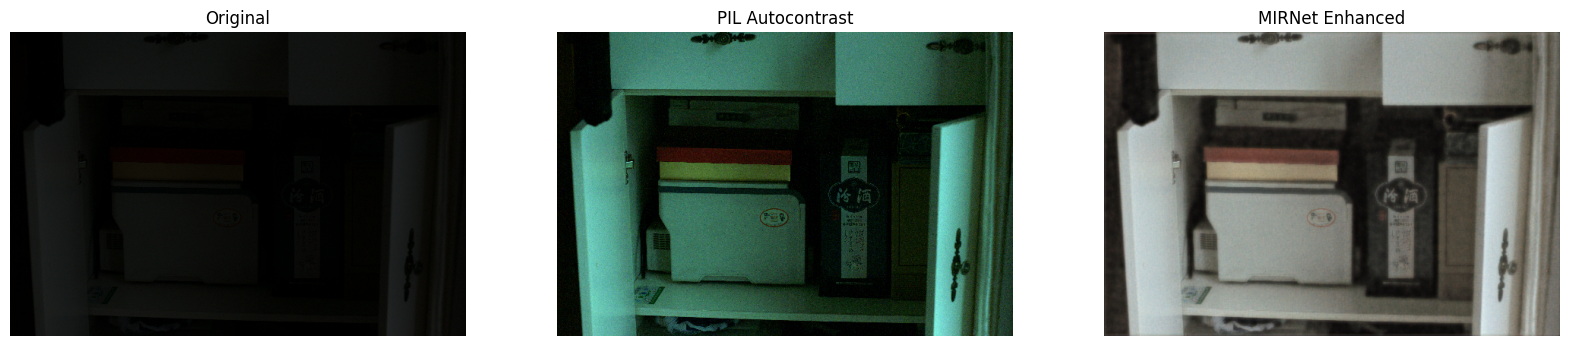

1/1 [==============================] - 1s 661ms/step


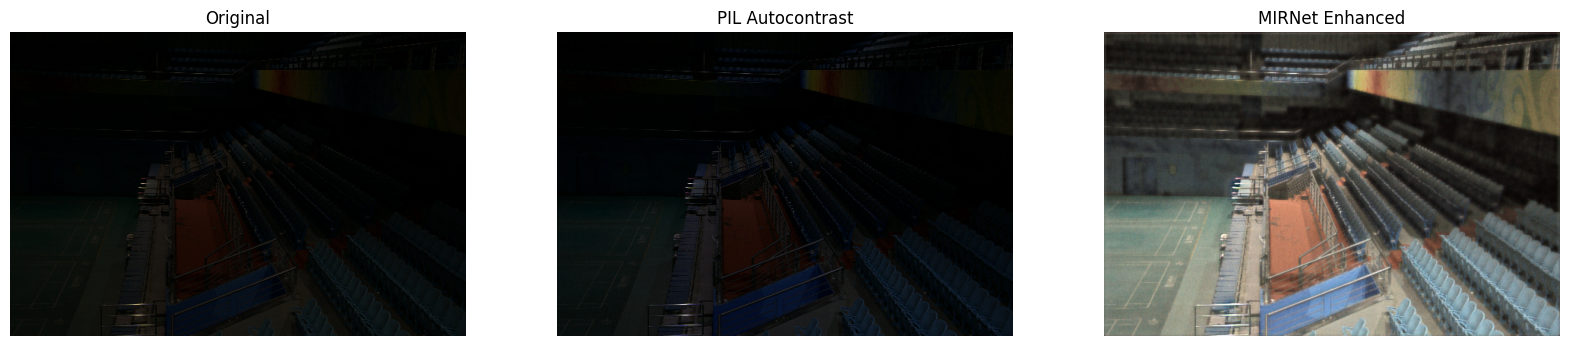

1/1 [==============================] - 1s 726ms/step


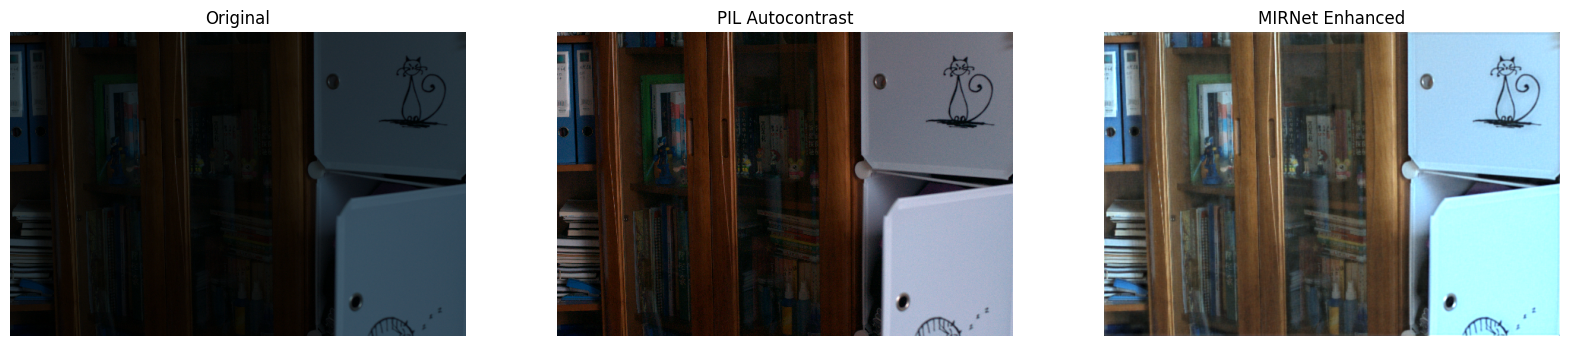

1/1 [==============================] - 1s 739ms/step


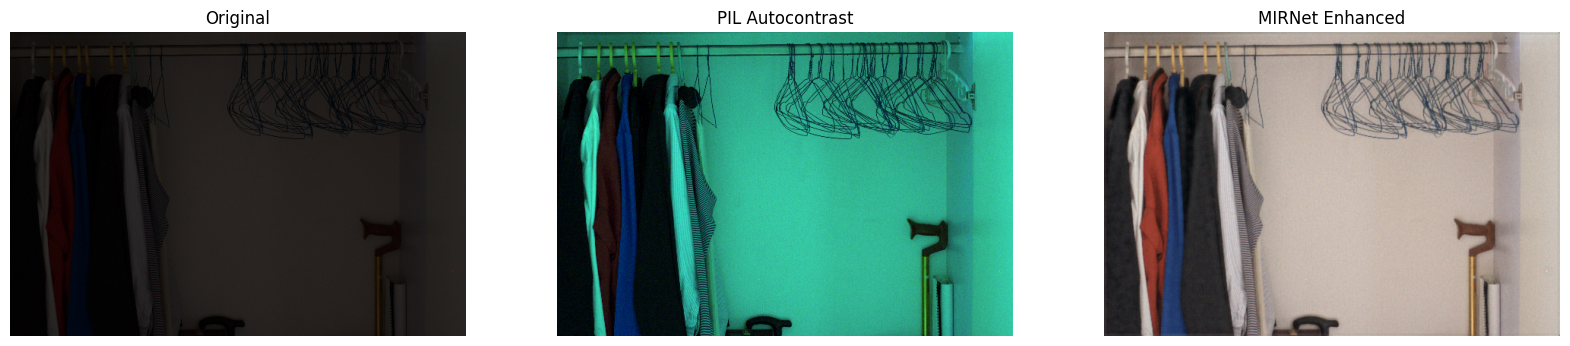

1/1 [==============================] - 1s 745ms/step


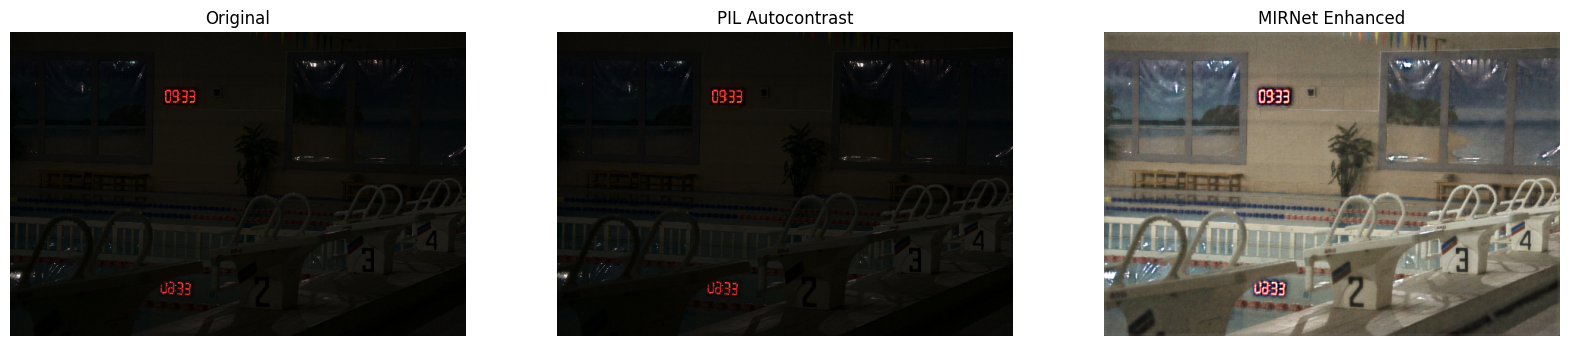

In [17]:
for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
        (20, 12),
    )